United Nations ComTrade API with Python
=====

## Bilateral trade data by product

----

*February 2026*<br>
*@bd_econ*

This example retrieves bilateral trade data from the [UN ComTrade](https://comtradeplus.un.org/) database using the public preview API, which is free and requires no API key.

**Limitations**: The free preview endpoint returns a maximum of 500 records per request. For larger queries, register for a free API key at [comtradeplus.un.org](https://comtradeplus.un.org/).

The API uses [UN M49 country codes](https://unstats.un.org/unsd/methodology/m49/) rather than ISO alpha-3 codes. Product codes follow the [Harmonized System (HS)](https://unstats.un.org/unsd/tradekb/Knowledgebase/50018/Harmonized-Commodity-Description-and-Coding-Systems-HS) classification at 2- or 6-digit granularity.

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import time

## Parameters/ Settings

The public preview endpoint:
```
https://comtradeapi.un.org/public/v1/preview/C/A/HS
```

URL structure: `/public/v1/preview/{typeCode}/{freqCode}/{classificationCode}`

Common country codes: 842 (USA), 156 (China), 392 (Japan), 276 (Germany), 826 (UK), 124 (Canada), 484 (Mexico)

### Example 1: US Exports by Product

US exports to China by 2-digit HS chapter.

In [2]:
base = 'https://comtradeapi.un.org/public/v1/preview/C/A/HS'

params = {
    'reporterCode': 842,    # USA
    'partnerCode': 156,     # China
    'period': 2023,
    'flowCode': 'X',        # Exports
    'cmdCode': 'AG2',       # All 2-digit HS chapters
}

r = requests.get(base, params=params)
data = r.json()
df = pd.DataFrame(data['data'])
print(f'{len(df)} product categories')

97 product categories


In [3]:
# Top 10 US export categories to China
hs_chapters = {
    '12': 'Oil seeds', '27': 'Mineral fuels', '29': 'Organic chemicals',
    '30': 'Pharmaceuticals', '39': 'Plastics', '84': 'Machinery',
    '85': 'Electrical machinery', '87': 'Vehicles', '88': 'Aircraft',
    '90': 'Optical/medical',
}

top = (df[['cmdCode', 'primaryValue']]
       .sort_values('primaryValue', ascending=False)
       .head(10)
       .reset_index(drop=True))
top['Billions USD'] = (top['primaryValue'] / 1e9).round(1)
top['Description'] = top['cmdCode'].map(hs_chapters)
top[['cmdCode', 'Description', 'Billions USD']]

,cmdCode,Description,Billions USD
0,27,Mineral fuels,19.7
1,12,Oil seeds,15.9
2,84,Machinery,13.7
3,85,Electrical machinery,11.6
4,90,Optical/medical,11.3
5,30,Pharmaceuticals,9.9
6,87,Vehicles,8.1
7,39,Plastics,7.4
8,88,Aircraft,6.8
9,29,Organic chemicals,4.2


### Example 2: Top US Import Sources

Total US imports by partner country. The preview API does not populate description fields, so we map M49 country codes to names manually.

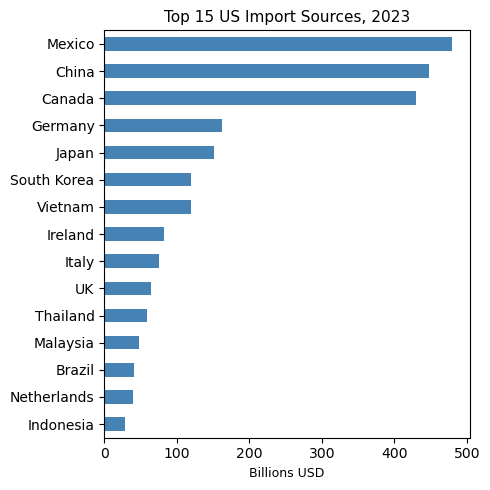

In [4]:
params = {
    'reporterCode': 842,    # USA
    'period': 2023,
    'flowCode': 'M',        # Imports
    'cmdCode': 'TOTAL',
}

r = requests.get(base, params=params)
df = pd.DataFrame(r.json()['data'])

# Filter to individual countries (exclude aggregates like World)
df = df[df['partnerCode'].between(1, 899)]

partner_names = {
    156: 'China', 484: 'Mexico', 124: 'Canada', 276: 'Germany',
    392: 'Japan', 410: 'South Korea', 826: 'UK', 356: 'India',
    158: 'Taiwan', 704: 'Vietnam', 380: 'Italy', 250: 'France',
    756: 'Switzerland', 372: 'Ireland', 764: 'Thailand',
    458: 'Malaysia', 36: 'Australia', 76: 'Brazil', 360: 'Indonesia',
    528: 'Netherlands', 56: 'Belgium', 682: 'Saudi Arabia',
}
df['Partner'] = df['partnerCode'].map(partner_names)
df = df.dropna(subset=['Partner'])

top15 = (df.sort_values('primaryValue', ascending=True)
           .tail(15)
           .set_index('Partner'))
top15['Billions USD'] = top15['primaryValue'] / 1e9

fig, ax = plt.subplots(figsize=(5, 5))
top15['Billions USD'].plot(kind='barh', color='steelblue', ax=ax)
ax.set_title('Top 15 US Import Sources, 2023', fontsize=11)
ax.set_xlabel('Billions USD', fontsize=9)
ax.set_ylabel('')
plt.tight_layout()
plt.show()

### Example 3: Semiconductor Trade Network

Using 6-digit HS codes, we can map trade flows for a specific product across countries. Here we build a directed network graph for **HS 854231** (processors and controllers) — the chips at the heart of the AI boom.

We query each country's exports to the others in our set, then visualize with [NetworkX](https://networkx.org/). Node size reflects total trade volume; edge width reflects the bilateral flow value. Taiwan is excluded because it does not report to UN ComTrade.

In [5]:
# Semiconductor supply chain countries
countries = {
    410: 'S. Korea', 156: 'China', 842: 'USA', 392: 'Japan',
    458: 'Malaysia', 702: 'Singapore', 704: 'Vietnam',
    764: 'Thailand', 608: 'Philippines',
}

product = '854231'  # Processors & controllers (HS 6-digit)
partner_list = ','.join(str(c) for c in countries.keys())

# Fetch each country's exports to the others in our set
raw = []
for code, name in countries.items():
    params = {
        'reporterCode': code,
        'partnerCode': partner_list,
        'period': 2023,
        'flowCode': 'X',
        'cmdCode': product,
    }
    r = requests.get(base, params=params)
    for row in r.json().get('data', []):
        if row['partnerCode'] in countries and row['partnerCode'] != code:
            raw.append((name, countries[row['partnerCode']],
                        row['primaryValue']))
    time.sleep(1.0)

# Aggregate duplicate records and convert to billions
trade = (pd.DataFrame(raw, columns=['from', 'to', 'value'])
           .groupby(['from', 'to'])['value'].sum()
           .reset_index())
trade['Billions USD'] = (trade['value'] / 1e9).round(1)

print(f'{len(trade)} bilateral flows')
trade.sort_values('value', ascending=False).head(10)[['from', 'to', 'Billions USD']]

72 bilateral flows


,from,to,Billions USD
16,Malaysia,China,15.2
32,S. Korea,China,11.6
64,Vietnam,China,10.9
40,Singapore,China,9.3
20,Malaysia,Singapore,8.3
23,Malaysia,Vietnam,8.2
22,Malaysia,USA,7.8
7,China,Vietnam,6.0
47,Singapore,Vietnam,5.0
39,S. Korea,Vietnam,4.7


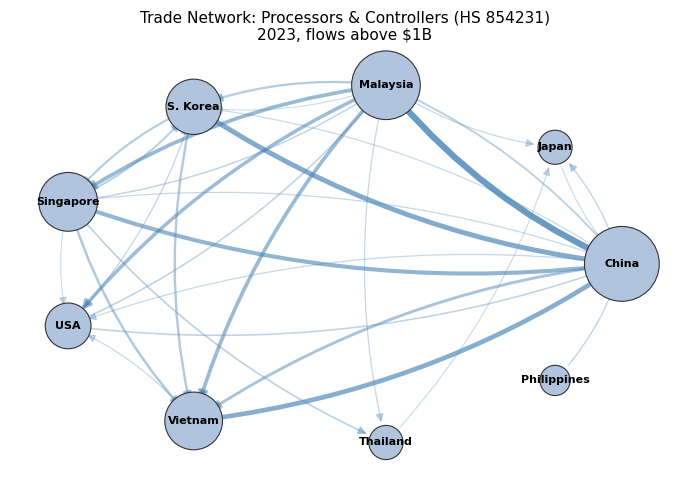

In [6]:
G = nx.DiGraph()
for _, row in trade[trade['value'] >= 1e9].iterrows():
    G.add_edge(row['from'], row['to'], weight=row['value'])

# Node size = total trade volume
node_total = {}
for n in G.nodes():
    node_total[n] = (
        sum(d['weight'] for _, _, d in G.out_edges(n, data=True)) +
        sum(d['weight'] for _, _, d in G.in_edges(n, data=True)))
max_t = max(node_total.values())
sizes = [400 + 2500 * node_total[n] / max_t for n in G.nodes()]

# Edge width and opacity = trade value
max_w = max(d['weight'] for *_, d in G.edges(data=True))
widths = [0.5 + 4 * d['weight'] / max_w for *_, d in G.edges(data=True)]
alphas = [0.25 + 0.55 * d['weight'] / max_w for *_, d in G.edges(data=True)]

pos = nx.kamada_kawai_layout(G)

fig, ax = plt.subplots(figsize=(7, 5))
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='lightsteelblue',
                       edgecolors='#333', linewidths=0.8, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax)

for (u, v, d), w, a in zip(G.edges(data=True), widths, alphas):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=w, alpha=a,
                           edge_color='steelblue', arrows=True, arrowsize=12,
                           connectionstyle='arc3,rad=0.12',
                           min_source_margin=15, min_target_margin=15, ax=ax)

ax.set_title('Trade Network: Processors & Controllers (HS 854231)\n'
             '2023, flows above $1B', fontsize=11)
ax.axis('off')
plt.tight_layout()
plt.show()